In [12]:
# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

In [11]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r
import random

anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
adata = sc.read("/home/d/danilina/masterprak/data/for_merge/Peyser_Merging.h5ad")
adata

AnnData object with n_obs × n_vars = 18686 × 19472
    obs: 'batch', 'condition', 'manual_celltype_annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'

In [3]:
adata.obs

,batch,condition,manual_celltype_annotation
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,saline,Interstitial Macrophage
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,saline,B-cells
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,saline,Lymphatic endothelial
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,saline,Alveolar macrophages
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,saline,Endothelial
...,...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,nintedanib,Classical monocytes
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,nintedanib,B-cells


In [4]:
list(adata.obs["condition"].cat.categories)

['bleomycin', 'nintedanib', 'saline']

In [5]:
# Store the counts for later use
adata.layers["counts"] = adata.X.copy()
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
for cond in list(adata.obs["condition"].cat.categories):
    adata_cond = adata[adata.obs["condition"]==cond].copy()
    #print("Running rank_aggregate on "+file[:-5]+", "+cond)
    rank_aggregate(
        adata_cond, groupby="manual_celltype_annotation", resource_name = 'mouseconsensus',
          return_all_lrs=True, use_raw=False, verbose=True)

    break

Using `.X`!
869 features of mat are empty, they will be removed.


/home/d/danilina/mambaforge/envs/scanpy_r/lib/python3.9/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Neutrophils


0.11 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 7091 samples and 18603 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:12<00:00, 78.95it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]


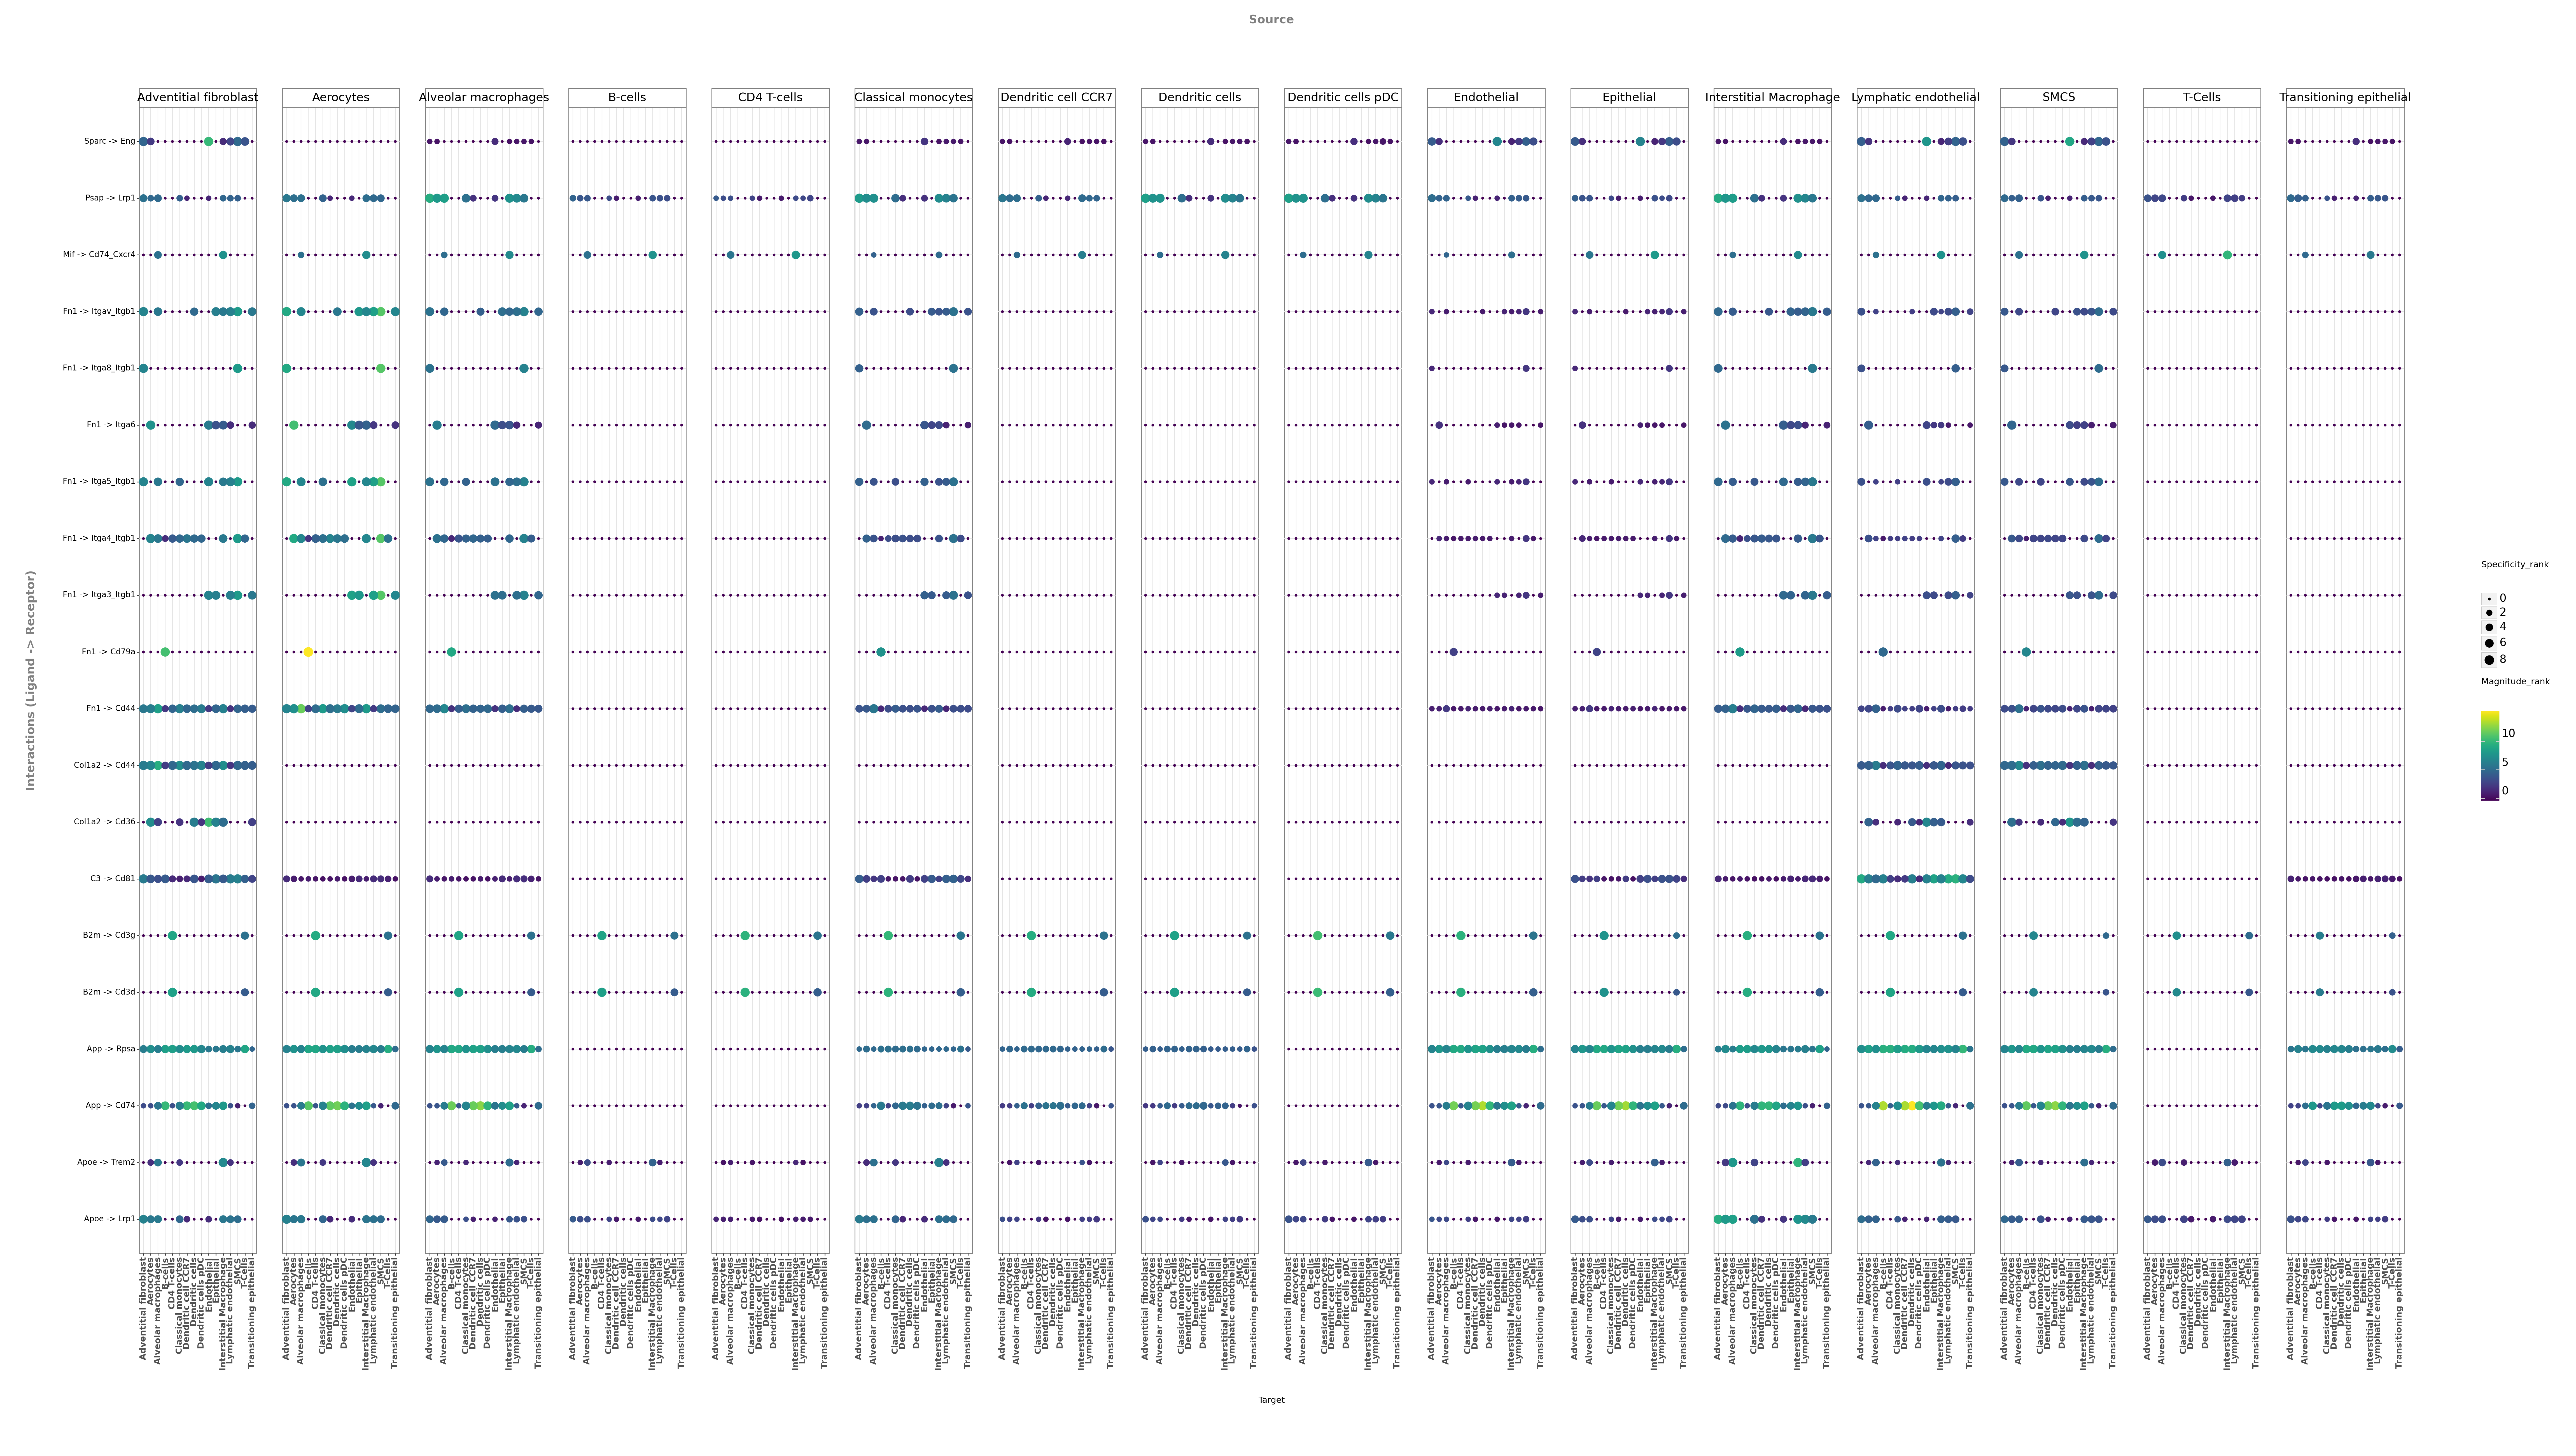

In [7]:
fig = li.pl.dotplot(
    adata=adata_cond,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(46, 26),
    size_range=(1, 6),
    return_fig=True
)   
#fig.save("./plots/"+file[:-5]+"_"+cond+"_liana.png", dpi=500, limitsize=False)
fig.draw()

In [8]:
type(adata_cond.uns["liana_res"])

pandas.core.frame.DataFrame

In [26]:
liana_res = adata_cond.uns["liana_res"].drop_duplicates(["ligand_complex", "receptor_complex"]).sort_values(["magnitude_rank", "specificity_rank"],)

In [13]:
%%R
# Increase timeout threshold
options(timeout=600)

# Load PK
ligand_target_matrix <- readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final_mouse.rds"))
lr_network <- readRDS(url("https://zenodo.org/record/7074291/files/lr_network_mouse_21122021.rds"))

In [14]:
sender_celltypes = ["Epithelial", "Fibroblasts", "Interstitial_macrophages"]
receiver_celltypes = ["Epithelial", "Fibroblasts", "Interstitial_macrophages"]

In [15]:
# Helper function to obtain sufficiently expressed genes
from functools import reduce


def get_expressed_genes(adata, cell_type, expr_prop):
    # calculate proportions
    temp = adata[adata.obs["manual_celltype_annotation"] == cell_type, :]
    a = temp.X.getnnz(axis=0) / temp.X.shape[0]
    stats = (
        pd.DataFrame({"genes": temp.var_names, "props": a})
        .assign(cell_type=cell_type)
        .sort_values("genes")
    )

    # obtain expressed genes
    stats = stats[stats["props"] >= expr_prop]
    expressed_genes = stats["genes"].values

    return expressed_genes

In [25]:
adata_cond[adata_cond.obs["manual_celltype_annotation"] == "Interstitial_macrophages", :]

View of AnnData object with n_obs × n_vars = 0 × 19472
    obs: 'batch', 'condition', 'manual_celltype_annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'log1p', 'liana_res'
    layers: 'counts'

In [18]:
sender_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata_cond, cell_type=cell_type, expr_prop=0.1)
        for cell_type in sender_celltypes
    ],
)
receiver_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata_cond, cell_type=cell_type, expr_prop=0.1)
        for cell_type in receiver_celltypes
    ],
)

/tmp/user/21175/ipykernel_119069/982473700.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/user/21175/ipykernel_119069/982473700.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/user/21175/ipykernel_119069/982473700.py:8: RuntimeWarning: invalid value encountered in divide
/tmp/user/21175/ipykernel_119069/982473700.py:8: RuntimeWarning: invalid value encountered in divide


In [27]:
liana_res

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
10973,Aerocytes,B-cells,Fn1,Cd79a,3.182969,0.0,9.851899,3.147797,3.502686,0.289033,0.968785,0.223944,0.0,5.572683e-09,1.304841e-15
21106,Lymphatic endothelial,Dendritic cells,App,Cd74,3.221438,0.0,7.133852,1.283277,1.495362,0.021783,0.963516,0.174935,0.0,5.627643e-08,1.454119e-15
7721,Aerocytes,Alveolar macrophages,Fn1,Cd44,2.719403,0.0,6.410803,2.099922,2.415545,0.072108,0.961591,0.159716,0.0,5.627643e-08,3.580332e-12
42122,Aerocytes,SMCS,Fn1,Itga4_Itgb1,2.628603,0.0,5.736786,2.113131,2.255137,0.054369,0.959486,0.141278,0.0,5.627643e-08,1.208335e-11
42124,Aerocytes,SMCS,Fn1,Itga8_Itgb1,2.628603,0.0,5.736786,2.113131,2.255137,0.054369,0.959486,0.141278,0.0,5.627643e-08,1.208335e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54883,Adventitial fibroblast,Adventitial fibroblast,Ceacam16,Tectb,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000056,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00
54808,Adventitial fibroblast,Adventitial fibroblast,Ntng2,Lrrc4c,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000056,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00
54880,Adventitial fibroblast,Adventitial fibroblast,F11,Gp5,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000056,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00
57244,Aerocytes,Adventitial fibroblast,Ihh,Ptch2_Smo,0.038849,1.0,0.001498,-1.270860,-3.072665,0.000056,0.276754,0.000000,1.0,1.000000e+00,1.000000e+00


In [37]:
liana_res.drop_duplicates(["source", "target"])

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
10973,Aerocytes,B-cells,Fn1,Cd79a,3.182969,0.0,9.851899,3.147797,3.502686,0.289033,0.968785,0.223944,0.0,5.572683e-09,1.304841e-15
21106,Lymphatic endothelial,Dendritic cells,App,Cd74,3.221438,0.0,7.133852,1.283277,1.495362,0.021783,0.963516,0.174935,0.0,5.627643e-08,1.454119e-15
7721,Aerocytes,Alveolar macrophages,Fn1,Cd44,2.719403,0.0,6.410803,2.099922,2.415545,0.072108,0.961591,0.159716,0.0,5.627643e-08,3.580332e-12
42122,Aerocytes,SMCS,Fn1,Itga4_Itgb1,2.628603,0.0,5.736786,2.113131,2.255137,0.054369,0.959486,0.141278,0.0,5.627643e-08,1.208335e-11
12946,Dendritic cells pDC,CD4 T-cells,B2m,Cd3g,2.506362,0.0,5.487245,1.523377,1.673850,0.055185,0.958613,0.146707,0.0,5.627643e-08,4.478816e-11
4602,Aerocytes,Aerocytes,Fn1,Itga6,2.501848,0.0,4.795871,2.705284,2.421781,0.156279,0.955857,0.129216,0.0,5.627643e-08,4.688719e-11
24563,Adventitial fibroblast,Endothelial,Col1a2,Cd36,2.465795,0.0,5.972156,2.232319,3.543720,0.186705,0.960260,0.153732,0.0,5.627643e-08,6.344334e-11
47602,Lymphatic endothelial,T-Cells,App,Rpsa,2.397772,0.0,4.794014,1.268473,1.054754,0.011819,0.955849,0.126518,0.0,6.519146e-07,1.442829e-10
36049,T-Cells,Interstitial Macrophage,Mif,Cd74_Cxcr4,2.380982,0.0,5.296200,1.229203,1.185945,0.015617,0.957904,0.132453,0.0,2.282952e-07,1.834407e-10
35055,Interstitial Macrophage,Interstitial Macrophage,Apoe,Trem2,2.364527,0.0,4.617485,1.141106,2.914186,0.102328,0.955051,0.128662,0.0,5.627643e-08,2.353014e-10


In [40]:
top_res = liana_res.drop_duplicates(["source", "target"])[:20]

In [41]:
list(top_res.source)

['Aerocytes',
 'Lymphatic endothelial',
 'Aerocytes',
 'Aerocytes',
 'Dendritic cells pDC',
 'Aerocytes',
 'Adventitial fibroblast',
 'Lymphatic endothelial',
 'T-Cells',
 'Interstitial Macrophage',
 'Lymphatic endothelial',
 'Adventitial fibroblast',
 'Alveolar macrophages',
 'Interstitial Macrophage',
 'SMCS',
 'Transitioning epithelial',
 'Aerocytes',
 'Adventitial fibroblast',
 'Interstitial Macrophage',
 'Dendritic cells']

In [42]:
sources = list(top_res.source)
targets = list(top_res.target)

In [44]:
len(sources)

20

In [45]:
for i in range (20):
    sender_celltypes = sources[i]
    receiver_celltypes = targets[i]
    print(sender_celltypes, receiver_celltypes)

Aerocytes B-cells
Lymphatic endothelial Dendritic cells
Aerocytes Alveolar macrophages
Aerocytes SMCS
Dendritic cells pDC CD4 T-cells
Aerocytes Aerocytes
Adventitial fibroblast Endothelial
Lymphatic endothelial T-Cells
T-Cells Interstitial Macrophage
Interstitial Macrophage Interstitial Macrophage
Lymphatic endothelial SMCS
Adventitial fibroblast Alveolar macrophages
Alveolar macrophages Adventitial fibroblast
Interstitial Macrophage Adventitial fibroblast
SMCS SMCS
Transitioning epithelial Epithelial
Aerocytes Epithelial
Adventitial fibroblast SMCS
Interstitial Macrophage Endothelial
Dendritic cells Dendritic cells pDC
